# Проект "Прогнозирование заказов такси на следующий час"

***Описание проекта***

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Нобходимо постройте модель для прогнозирования заказов такси на следующий час.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

***Этапы выполения работы:***

1. Загрузить данные и выполните их ресемплирование по одному часу.

2. Анализ данных.

3. Обучение разных моделей с различными гиперпараметрами (размер тестовуой выборки - 10% от исходных данных).

4. Проверкае данные на тестовой выборке и сделайте выводы.

***Описание данных***

Данные лежат в файле /datasets/taxi.csv. 
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

## 1. Подготовка

***Тут будут все импорты***

In [1]:
!pip install statsmodels -q

In [3]:
import pandas as pd
import numpy as np
import time

import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error,make_scorer,mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose


In [4]:
#загрузка данных
from io import BytesIO
import requests
spreadsheet_id = '1He-SoMnBAnPYHWyaJE6c8BWys1VdmNCxodUK24oe0J4'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data = pd.read_csv(BytesIO(r.content))
data 


,datetime,num_orders
0,2018-03-01 0:00:00,9
1,2018-03-01 0:10:00,14
2,2018-03-01 0:20:00,28
3,2018-03-01 0:30:00,20
4,2018-03-01 0:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [5]:
#информция по данным и просмотр пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
#ресемплирование по одному часу

data = pd.read_csv(BytesIO(r.content), index_col=[0], parse_dates=[0])
data= data.sort_index()
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


***Вывод:***
Пропусков в данных нет. Данные представлены за период 01.03.2018 - 31.08.2018

## 2. Анализ

In [9]:
data['num_orders'].unique()

array([  9,  14,  28,  20,  32,  21,   7,   5,  17,  12,  19,  25,  22,
         8,   6,   4,  10,  13,   2,   3,   0,   1,  11,  15,  16,  23,
        18,  33,  24,  26,  30,  38,  34,  42,  31,  27,  36,  29,  35,
        56,  37,  40,  39,  45,  49,  58,  68,  43,  53,  44,  41,  52,
        46,  57,  47,  64,  61,  50,  48,  55,  62,  54,  71,  78, 119,
        99,  51,  60,  87,  90,  94,  82,  80,  91,  76,  66,  65,  98,
        81,  95,  67])

In [10]:
#проверим в хронологическом ли порядке расположены даты и время
print(data.index.is_monotonic)

True


In [11]:
#выполним ресемплирование данных по 1 часу
data = data.resample('1H').sum()

In [12]:
#выполним ресемплирование данных по 1 неделе и 1 месяцу 

data1 = data.resample('1W').mean()
data2 = data.resample('1D').mean()

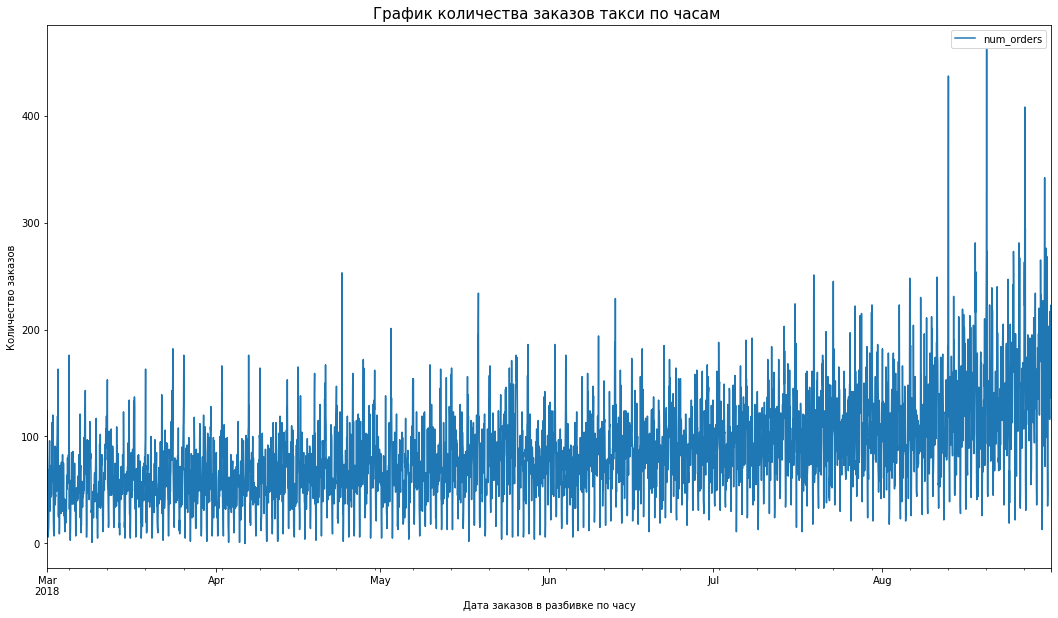

In [13]:
#построим график
figsize = (18,10)
data.plot(figsize=figsize)

plt.xlabel('Дата заказов в разбивке по часу')
plt.ylabel('Количество заказов')
plt.title('График количества заказов такси по часам ', fontsize=15);

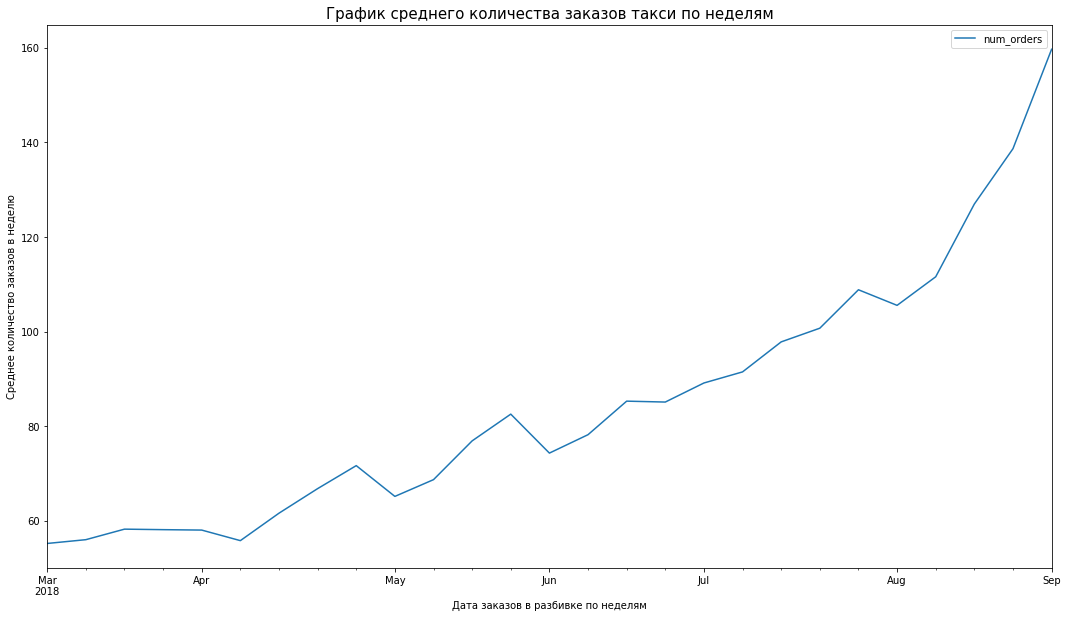

In [14]:
#построим график
figsize = (18,10)
data1.plot(figsize=figsize)

plt.xlabel('Дата заказов в разбивке по неделям')
plt.ylabel('Среднее количество заказов в неделю')
plt.title('График среднего количества заказов такси по неделям', fontsize=15);

In [15]:
data2.head()

,num_orders
datetime,
2018-03-01,56.833333
2018-03-02,62.750000
2018-03-03,53.750000
2018-03-04,47.541667
2018-03-05,52.458333


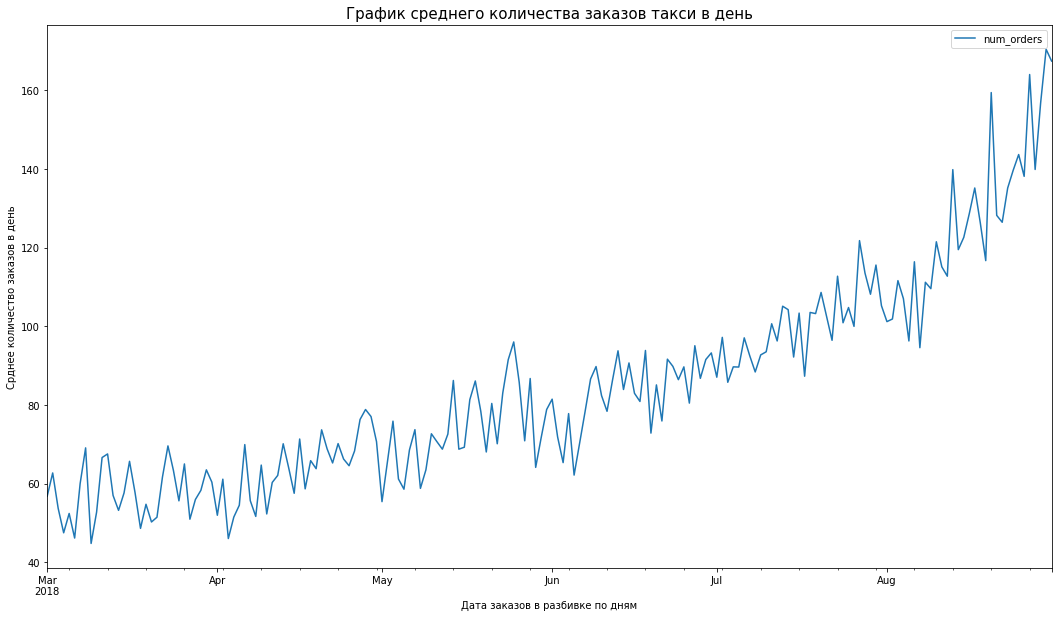

In [16]:
#построим график
figsize = (18,10)
data2.plot(figsize=figsize)

plt.xlabel('Дата заказов в разбивке по дням')
plt.ylabel('Срднее количество заказов в день')
plt.title('График среднего количества заказов такси в день', fontsize=15);

Если сделать ресемплирвоание данных по днмя и неделям и найти среднее их колчество, то видна явная тенденция роста числа заказов.

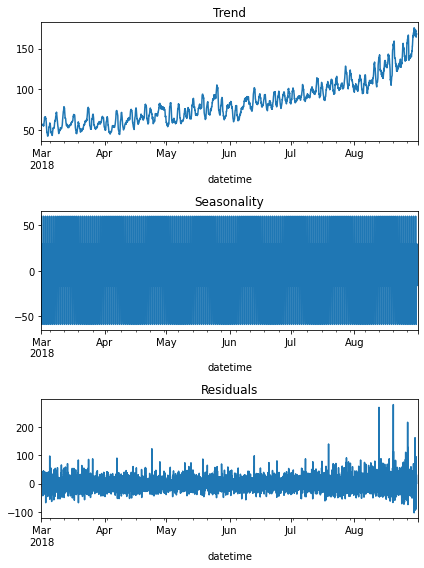

In [17]:
#разложим временной ряд на тренд и сезонную компоненту

decomposed = seasonal_decompose(data) 
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
# < напишите код здесь >
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
# < напишите код здесь >
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Рассмотрим график сезоности в большем масштабе, сделаем срез за месяц, так как судя по графику выше сезонность стабильная.

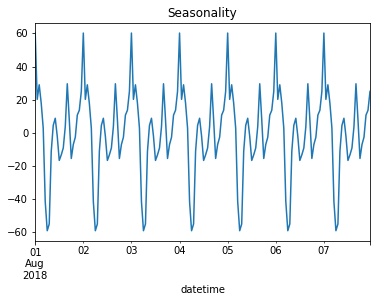

In [18]:
#ecomposed = seasonal_decompose(data) 
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca())
plt.title('Seasonality');


Видим определенную сезоность в пределах дня. Рассмотрим ее ниже в масштабе 1 дня.

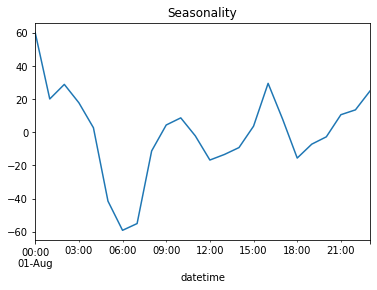

In [19]:
#ecomposed = seasonal_decompose(data) 
decomposed.seasonal['2018-08-01':'2018-08-01'].plot(ax=plt.gca())
plt.title('Seasonality');


***Вывод по графикам*** 

Есть тренд по увеличении заказов со временем. При увеличении масштаба на графике сезонности можно отметить точки наибольшего спроса на такси - это время около 16.00  и 00.00 часов.
Также есть выбросы, но их удалять не буду, так как данных немного. 

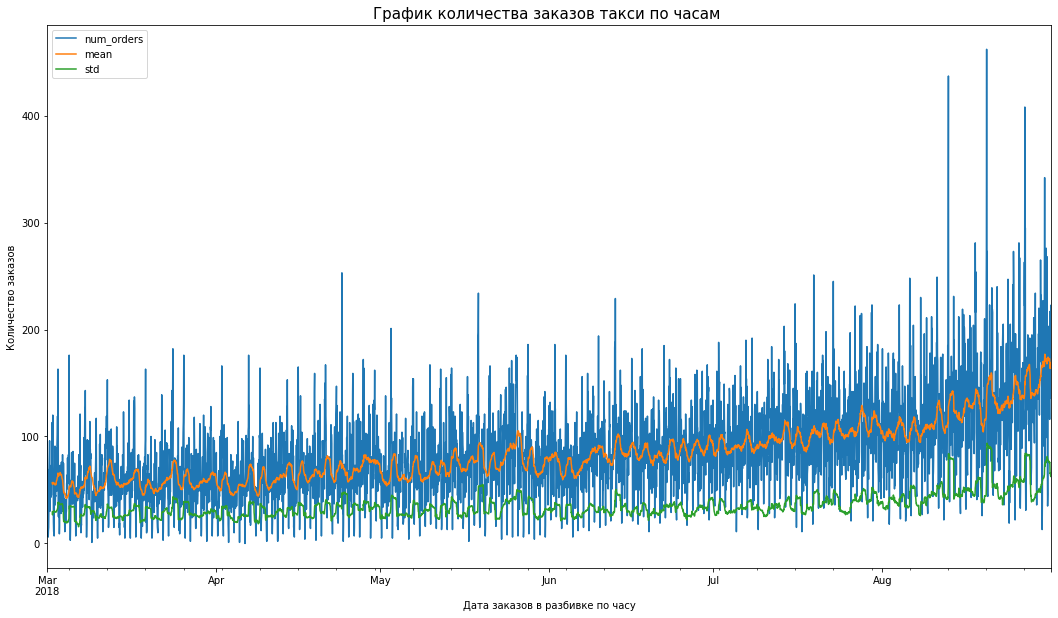

In [20]:
data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()
data.plot(figsize=figsize)
plt.xlabel('Дата заказов в разбивке по часу')
plt.ylabel('Количество заказов')
plt.title('График количества заказов такси по часам ', fontsize=15);

Мы имеем нестанционарный временной ряд, так как его среднее значение  (mean на графике) и стандартное отклоение (std) меняется.

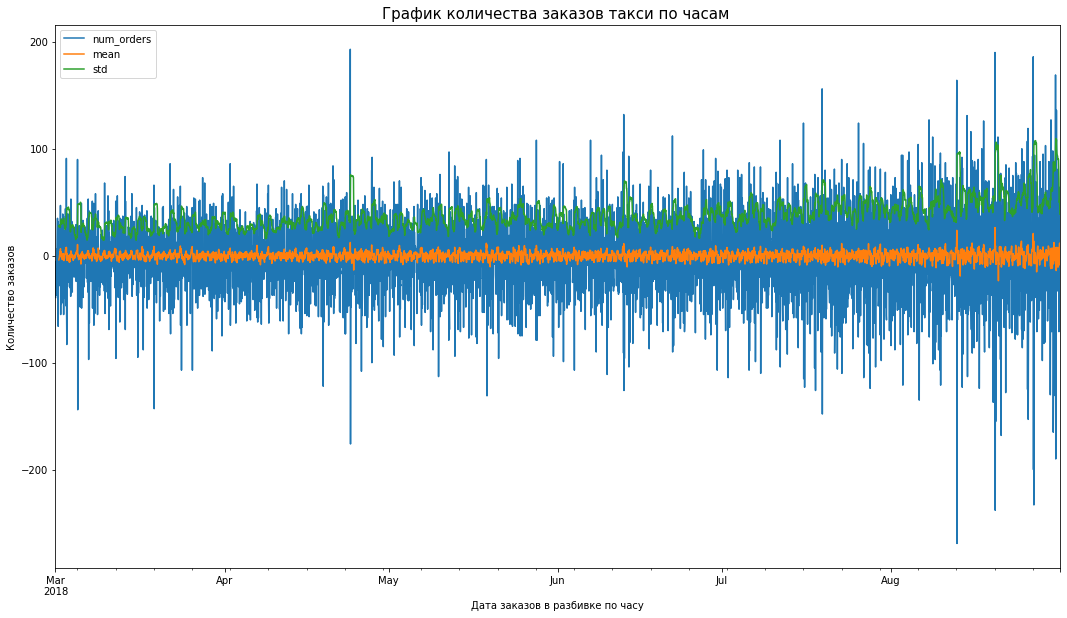

In [21]:
#сделаем ряд стационарным - найдем разности значений между соседними элеметтами ряда.
data1 = data - data.shift()
data1['mean'] = data1['num_orders'].rolling(15).mean()
data1['std'] = data1['num_orders'].rolling(15).std()
data1.plot(figsize=figsize)
plt.xlabel('Дата заказов в разбивке по часу')
plt.ylabel('Количество заказов')
plt.title('График количества заказов такси по часам ', fontsize=15);

***Вывод:***
Мы видим, что ряд стал более стационарным, следовательно, данные можно прогнозировать.


***Добавим новые признаки в датсет для обучения модели***

In [22]:
#создание новых признаков
#data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day

def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

#примем следующие параметры: max_lag = 24 часам, rolling_mean_size = 48 часов (за 2 суток)
make_features(data, 168, 48)
data.head()

,num_orders,mean,std,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,2,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,4,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
data = data.drop('mean', axis=1)
data = data.drop('std', axis=1)

In [24]:
data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Все данные количественные. Надо будет провест масштабирвоание.

In [25]:
#по условия задачи размер тестовой выборки должен быть равен 10%

test_size = data.shape[0] * 0.1
print('Размер тестовой выборки по условиям задачи должен быть равен =', round(test_size))

Размер тестовой выборки по условиям задачи должен быть равен = 442


In [26]:
#разделим данные на обучающую и тестовую выборки

train, test = train_test_split(data, shuffle=False, test_size=0.1)

print('Тренировочная выборка:', train.shape)
print('Тестовая выбока', test.shape)

Тренировочная выборка: (3974, 172)
Тестовая выбока (442, 172)


In [27]:
#из тренировочной выборки удалим строки с пропусками
train = train.dropna()
train.shape

(3806, 172)

In [28]:
#выделяем признаки и целевой признак
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

***Масштабирование данных***

In [29]:
#выведем название колонок

features_train.columns

Index(['hour', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8',
       ...
       'lag_160', 'lag_161', 'lag_162', 'lag_163', 'lag_164', 'lag_165',
       'lag_166', 'lag_167', 'lag_168', 'rolling_mean'],
      dtype='object', length=171)

In [30]:
#масштабирование данных для моделей

#выделим количественные признаким (у нас они все количественные)

numeric=features_train.columns

#создадим объект стандартизации и обучим его для моделей Л
scaler = StandardScaler()    
scaler.fit(features_train[features_train.columns])

#сохраним преобразованные обучающую и тестовую  выборки в переменные
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

#features_train_scaled = scaler.transform(features_train[numeric])

#features_test_scaled = scaler.transform(features_test[numeric])


pd.options.mode.chained_assignment = None

In [31]:
#сбросим индексы, чтобы в дальнейшем было проще сопостовлять данные в target и prediction

features_train = features_train.reset_index(drop=True)

features_test = features_test.reset_index(drop=True)

features_train.head()

Данные подготовлены для обучения.

## 3. Обучение

Обучим данные на 4-х видах моделей и выберем лучшею: Линейная регрессия, Дерево решений, Случайного леса и LightGBM.

В качестве метрики будем использовать среднеквадратическую ошибку RMSE, которая показывает разницу между прогнозируемым и фактическим значением. 

In [32]:
#сохраним randon_state в отдельную переменную
RANDOM_STATE = 12345

***Обучение модели Линейной регрессии***

In [33]:
#модель Линейной регрессии
model_lr = LinearRegression()



model_lr.fit(features_train, target_train)                  
prediction = model_lr.predict(features_train)
tscv = TimeSeriesSplit(n_splits=5)
scores_list = cross_val_score(estimator=model_lr, 
                              X=features_train, 
                              y=target_train, 
                              cv=tscv,  
                              scoring= 'neg_root_mean_squared_error')

score_lr = scores_list.mean()
print(score_lr)

-22.583597777522094


In [35]:
from sklearn.metrics import make_scorer
def rmse (target, prediction):
    return np.sqrt(mean_squared_error(target, prediction))

scorer = make_scorer(rmse)

tscv = TimeSeriesSplit(n_splits=5)
scores_list = cross_val_score(estimator=model_lr, 
                              X=features_train, 
                              y=target_train, 
                              cv=tscv,  
                              scoring= scorer)

score_lr = scores_list.mean()
print(score_lr)

22.583597777522094


***Обучение модели Случайного леса***

In [33]:
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

In [34]:
%%time
parametrs = {
    'n_estimators': range (1,10, 2),
    'max_depth': range (1,20, 2),
    'min_samples_leaf': range (1,10,2)                     
}
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(model_rf,
                     parametrs, cv=tscv, scoring = 'neg_root_mean_squared_error', verbose=3)
grid.fit(features_train, target_train)
#выводим результат
print(grid.best_params_)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV 1/5] END max_depth=1, min_samples_leaf=1, n_estimators=1;, score=-27.682 total time=   0.0s
[CV 2/5] END max_depth=1, min_samples_leaf=1, n_estimators=1;, score=-30.638 total time=   0.0s
[CV 3/5] END max_depth=1, min_samples_leaf=1, n_estimators=1;, score=-28.086 total time=   0.0s
[CV 4/5] END max_depth=1, min_samples_leaf=1, n_estimators=1;, score=-34.470 total time=   0.0s
[CV 5/5] END max_depth=1, min_samples_leaf=1, n_estimators=1;, score=-46.940 total time=   0.0s
[CV 1/5] END max_depth=1, min_samples_leaf=1, n_estimators=3;, score=-25.727 total time=   0.0s
[CV 2/5] END max_depth=1, min_samples_leaf=1, n_estimators=3;, score=-30.787 total time=   0.0s
[CV 3/5] END max_depth=1, min_samples_leaf=1, n_estimators=3;, score=-27.202 total time=   0.0s
[CV 4/5] END max_depth=1, min_samples_leaf=1, n_estimators=3;, score=-33.083 total time=   0.0s
[CV 5/5] END max_depth=1, min_samples_leaf=1, n_estimators=3;, score=-43

In [35]:
score_rf = grid.best_score_

***Обучение модели Дерево решений***

In [36]:
#модель
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [37]:
%%time
#подбор параметров

#параметры
parametrs = { 'max_depth': range (1,20, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2)
            }

def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
    score = sqrt(mean_squared_error(target_test, pred_lr))
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)
tscv = TimeSeriesSplit(n_splits=5)

#запускаем обучение
grid = GridSearchCV(model_dtr, parametrs, cv=tscv, scoring = 'neg_root_mean_squared_error', verbose=3)
grid.fit(features_train, target_train)

#выводим результат
print(grid.best_params_)


Fitting 5 folds for each of 280 candidates, totalling 1400 fits
[CV 1/5] END max_depth=1, min_samples_leaf=1, min_samples_split=2;, score=-26.994 total time=   0.0s
[CV 2/5] END max_depth=1, min_samples_leaf=1, min_samples_split=2;, score=-30.733 total time=   0.0s
[CV 3/5] END max_depth=1, min_samples_leaf=1, min_samples_split=2;, score=-28.123 total time=   0.0s
[CV 4/5] END max_depth=1, min_samples_leaf=1, min_samples_split=2;, score=-32.682 total time=   0.0s
[CV 5/5] END max_depth=1, min_samples_leaf=1, min_samples_split=2;, score=-44.953 total time=   0.0s
[CV 1/5] END max_depth=1, min_samples_leaf=1, min_samples_split=4;, score=-26.994 total time=   0.0s
[CV 2/5] END max_depth=1, min_samples_leaf=1, min_samples_split=4;, score=-30.733 total time=   0.0s
[CV 3/5] END max_depth=1, min_samples_leaf=1, min_samples_split=4;, score=-28.123 total time=   0.0s
[CV 4/5] END max_depth=1, min_samples_leaf=1, min_samples_split=4;, score=-32.682 total time=   0.0s
[CV 5/5] END max_depth=1, m

In [38]:
score_dtr = grid.best_score_
score_dtr

-26.59323361437394

***Обучение модели LGBMRegressor***

In [39]:
#модель 
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

In [40]:
%%time
#подбор параметров

#параметры

parametrs = {
    'max_depth':[3, 5, 6, 7, 9, 12, 15, 17, 25],
    'n_estimators': (150,251, 50),
    'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
    'num_leaves': [1, 10, 2]
}
tscv = TimeSeriesSplit(n_splits=5)
#запускаем обучение
grid = GridSearchCV(model_lgbm, parametrs, cv=tscv, scoring = 'neg_root_mean_squared_error', verbose=3)
grid.fit(features_train, target_train)

#выводим результат
print(grid.best_params_)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=150, num_leaves=1;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=150, num_leaves=1;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=150, num_leaves=1;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=150, num_leaves=1;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=150, num_leaves=1;, score=nan total time=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17085
[LightGBM] [Info] Number of data points in the train set: 636, number of used features: 171
[LightGBM] [Info] Start training from score 57.938679
[LightGBM] [Warning] No further splits with positive 

In [41]:
score_lgbm = grid.best_score_
score_lgbm

-16.69295782838668

***Выбор лучшей модели***

In [42]:
# Создание DataFrame с результатами
pd.options.display.width = 0
pd.set_option('display.expand_frame_repr', False)
results_valid = pd.DataFrame({'Model': ['LinearRegression','RandomForestRegressor', 'DecisionTreeRegressor', 'LGBMRegressor'],
                        'RMSE': [score_lr, score_rf, score_dtr, score_lgbm]
                        })

# Вывод результатов
display(results_valid)

,Model,RMSE
0,LinearRegression,-22.657425
1,RandomForestRegressor,-23.734257
2,DecisionTreeRegressor,-26.593234
3,LGBMRegressor,-16.692958


***Анализ метрик моделей:*** 

Лучший результат на валидацонных данных показала модель LGBMRegressor, ее метриика составила -16,629

Проверим работу этой модели на тестовой выборке.




## 4. Тестирование

In [44]:
#модель LGBMRegressor
predictions_test_lgbm = grid.predict(features_test)                            
rmse_lgbm_test = sqrt(mean_squared_error(target_test, predictions_test_lgbm))
print('RMSE модели LGBMRegressor на тестовой выбоорке:', rmse_lgbm_test) 

RMSE модели LGBMRegressor на тестовой выбоорке: 37.192241770063646


По тестовой выборке модель показала немного большую метрику RMSE, но все равно она в пределах условия - иниже 48. 

***Вывод:***

В проекте была задача на основании исторических данных о заказ такси в аэропортах построить модель для прогнозирования заказов такси на следующий час. При этом значение метрики RMSE на тестовой выборке должно быть не больше 48.

Мы провели анализ данных - они представлены за период 01.03.2018 - 31.08.2018 в разбивке по 10 минут. Далее сделали ресемплинг данных по 1 часу, так в задача проекта спрогнозировать заказы такси на следующий час. Проанализировали тренд и сезонность. Для сезонности у нас выборка за меленький период, поэтому график ничего не показал. Но по тренду видно постепенное увеличение количества заказов на такси.

Для обучения моделей мы разделили данные на 2 выборки. Провели их масштабирование. Обучили 4 модели: LinearRegression, RandomForestRegressor, DecisionTreeRegressor и LGBMRegressor.

Провели ранжирование моделей на валидационной выборке и финальное тестирование на тестовой. По итогу все модели удовлетворяют условию залачи - их RMSE меньше 48, но выбрали для тестирования одну лучшую - ей стала модель LGBMRegressor, с RMSE на кросвалидации  = 16,692 и на тестовой выборке = 37,192.
 

## 5. Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48